# Experiments (Main Paper)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

from dataset import CompasDataset, CreditDataset, DiabetesDataset
from simulator import Simulator
from explainer import BaselineExplainer, LinucbExplainer, BwoucbExplainer

plt.rcParams["font.family"] = 'arial'
plt.rcParams['text.usetex'] = True
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']
markers = ['o', 's', '^', 'v']
fontsize = 14

In [2]:
def run_comparison(
    dataset, 
    methods=['ProtoAR', 'TAP', 'LinUCB', 'BwOUCB'],
    estimator=RandomForestClassifier(), 
    n_trials=10, 
    n_timeout=10,
    max_counterfactuals=200,
    cost_types=('norm', 'norm'),
    delay_type=0.2,
    improvement_noise=0.1,
    probability_noise=0.0,
    verbose=True,
):
    np.random.seed(0)
    results = {}
    simulator = Simulator(
        estimator, 
        dataset, 
        n_timeout=n_timeout,
        max_counterfactuals=max_counterfactuals,
        cost_type=cost_types[0], 
        delay_type=delay_type, 
        improvement_noise=improvement_noise, 
        probability_noise=probability_noise
    )

    for method in methods:
        if method == 'ProtoAR':
            explainer = BaselineExplainer(cost_type=cost_types[1])
        elif method == 'TAP':
            explainer = BaselineExplainer(cost_type=cost_types[1], fit_verifier=True)
        elif method == 'LinUCB':
            explainer = LinucbExplainer(cost_type=cost_types[1])
        elif method == 'BwOUCB':
            explainer = BwoucbExplainer()
            
        results[method] = {}
        for n_trial in tqdm(range(n_trials), disable=(not verbose)):
            result = simulator.run(explainer)
            for key in result.keys():
                if n_trial == 0:
                    results[method][key] = np.zeros((n_trials, simulator.n_rounds))
                results[method][key][n_trial] = result[key]
    
    return results

In [3]:
def scatter_results(results, key1='improvement', key2='cost', figsize=(12, 2.5)):
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        results_dataset = results[dataset]
        methods = results_dataset.keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            x = results_dataset[method][key1]
            y = results_dataset[method][key2]
            plt.scatter(x.mean(axis=1), y.mean(axis=1), label=method, c=colors[i], s=75, marker=markers[i])
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel('Average {}'.format(key1.replace('_', ' ').title()), fontsize=fontsize)
        plt.ylabel('Average {}'.format(key2.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()


def plot_results(results, key='mean_reward', figsize=(12, 2.5)):
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        results_dataset = results[dataset]
        methods = results_dataset.keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            y = results_dataset[method][key]
            x = np.arange(y.shape[1])
            plt.plot(x, y.mean(axis=0), label=method, c=colors[i])
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel('Number of Rounds', fontsize=fontsize)
        if key == 'mean_expected_reward':
            plt.ylabel('Average MER', fontsize=fontsize)
        else:
            plt.ylabel('Average {}'.format(key.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()


def errorbar_result(results, key='mean_reward', xlabel='', line_method=[], figsize=(8, 2.5)): 
    fig = plt.figure(figsize=figsize)
    for j, dataset in enumerate(results.keys()):
        results_dataset = results[dataset]
        x = list(results_dataset.keys())
        methods = results_dataset[x[0]].keys()
        plt.subplot(1, len(results.keys()), j+1)
        for i, method in enumerate(methods):
            if key in ['mean_expected_reward', 'cumulative_regret', 'mean_reward']:
                y = np.array([results_dataset[param][method][key][:, -1] for param in x])
            else:
                y = np.array([results_dataset[param][method][key].mean(axis=1) for param in x])
            if method in line_method:
                plt.axhline(y[0].mean(), color=colors[i], label=method, linestyle='dashed') 
                plt.axhspan(y[0].mean()-y[0].std(), y[0].mean()+y[0].std(), facecolor=colors[i], alpha=0.25)
            else:
                plt.errorbar(x, y.mean(axis=1), y.std(axis=1), marker=markers[i], c=colors[i], markersize=5, capsize=5, label=method)
        plt.grid()
        plt.title(dataset, fontsize=fontsize)
        plt.xlabel(xlabel, fontsize=fontsize)
        if key == 'mean_expected_reward':
            plt.ylabel('Average MER', fontsize=fontsize)
        else:
            plt.ylabel('Average {}'.format(key.replace('_', ' ').title()), fontsize=fontsize)
        if j==0: plt.legend()
        plt.tight_layout()
    

## 01. Comparison under Noiseless Cost Evaluation

In [4]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset)

with open('./res/01_comparison_without_noise.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 10/10 [03:12<00:00, 19.27s/it]


Diabetes


100%|██████████| 10/10 [02:59<00:00, 18.00s/it]


COMPAS


100%|██████████| 10/10 [02:53<00:00, 17.39s/it]


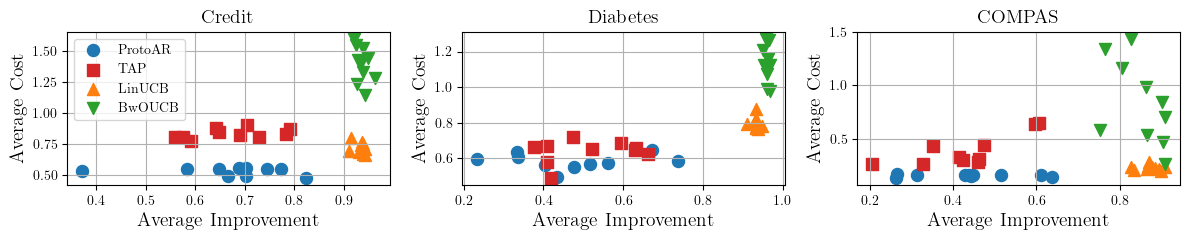

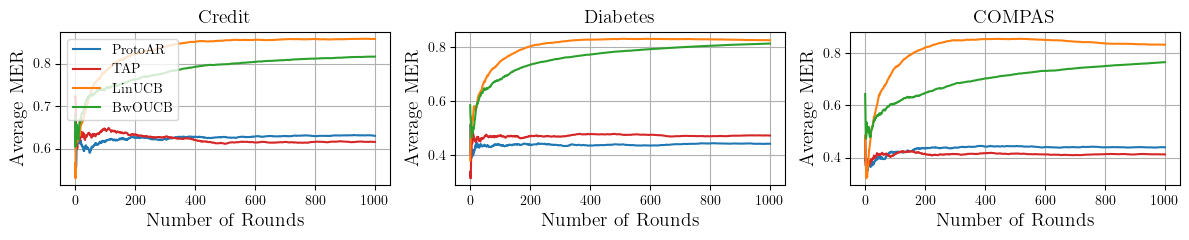

In [5]:
with open('./res/01_comparison_without_noise.pkl', 'rb') as f:
    results = pickle.load(f)
    
scatter_results(results, key1='improvement', key2='cost')
plt.savefig('./fig/01_comparison_without_noise_scatter.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/01_comparison_without_noise_scatter.pdf', bbox_inches='tight', pad_inches=0.05)

plot_results(results, key='mean_expected_reward')
plt.savefig('./fig/01_comparison_without_noise_plot.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/01_comparison_without_noise_plot.pdf', bbox_inches='tight', pad_inches=0.05)

## 02. Comparison under Noisy Cost Evaluation

In [6]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = run_comparison(dataset, probability_noise=0.25)

with open('./res/02_comparison_with_noise.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 10/10 [03:12<00:00, 19.27s/it]


Diabetes


100%|██████████| 10/10 [03:00<00:00, 18.05s/it]


COMPAS


100%|██████████| 10/10 [02:56<00:00, 17.62s/it]


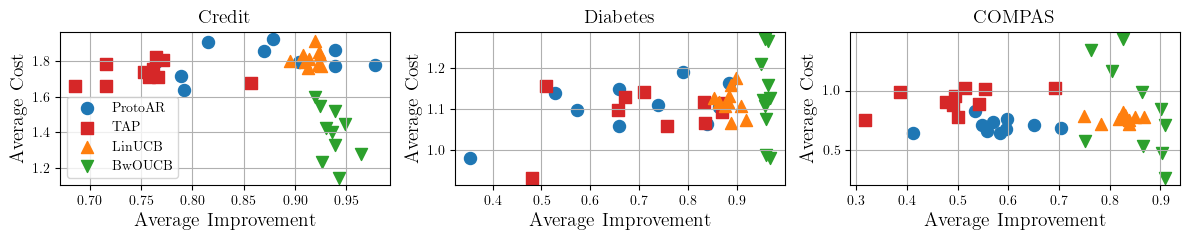

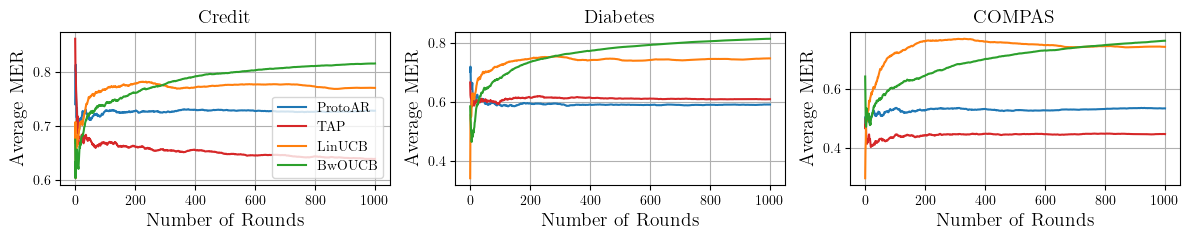

In [7]:
with open('./res/02_comparison_with_noise.pkl', 'rb') as f:
    results = pickle.load(f)
    
scatter_results(results, key1='improvement', key2='cost')
plt.savefig('./fig/02_comparison_with_noise_scatter.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/02_comparison_with_noise_scatter.pdf', bbox_inches='tight', pad_inches=0.05)

plot_results(results, key='mean_expected_reward')
plt.savefig('./fig/02_comparison_with_noise_plot.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/02_comparison_with_noise_plot.pdf', bbox_inches='tight', pad_inches=0.05)

In [8]:
results = {}
for dataset in [CreditDataset(), DiabetesDataset(), CompasDataset()]:
    print(dataset.name)
    results[dataset.name] = {}
    for probability_noise in tqdm([0.0, 0.05, 0.1, 0.15, 0.2, 0.25]):
        results[dataset.name][probability_noise] = run_comparison(dataset, probability_noise=probability_noise, n_trials=5, verbose=False)

with open('./res/03_sensitivity_of_noise.pkl', 'wb') as f: 
    pickle.dump(results, f)

Credit


100%|██████████| 6/6 [13:50<00:00, 138.40s/it]


Diabetes


100%|██████████| 6/6 [11:18<00:00, 113.09s/it]


COMPAS


100%|██████████| 6/6 [11:15<00:00, 112.58s/it]


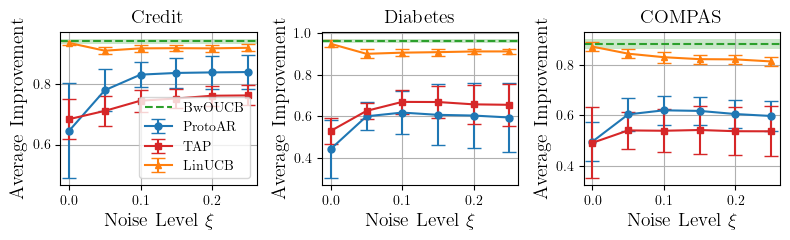

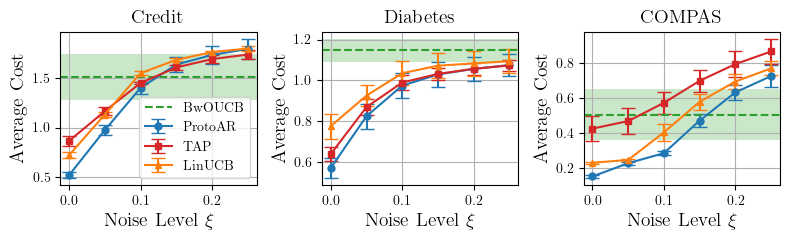

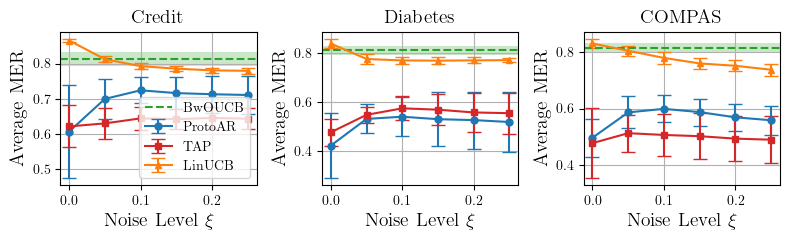

In [9]:
with open('./res/03_sensitivity_of_noise.pkl', 'rb') as f:
    results = pickle.load(f)

errorbar_result(results, key='improvement', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
plt.savefig('./fig/03_sensitivity_of_noise_improvement.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/03_sensitivity_of_noise_improvement.pdf', bbox_inches='tight', pad_inches=0.05)
    
errorbar_result(results, key='cost', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
plt.savefig('./fig/03_sensitivity_of_noise_cost.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/03_sensitivity_of_noise_cost.pdf', bbox_inches='tight', pad_inches=0.05)

errorbar_result(results, key='mean_expected_reward', xlabel=r'Noise Level $\xi$', line_method=['BwOUCB'])
plt.savefig('./fig/03_sensitivity_of_noise_reward.png', bbox_inches='tight', pad_inches=0.05)
plt.savefig('./fig/03_sensitivity_of_noise_reward.pdf', bbox_inches='tight', pad_inches=0.05)